<a href="https://colab.research.google.com/github/iamvikashk/SeoulBikeSharing/blob/main/SeoulBikeSharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN Regression on Bike Sharing Dataset

## Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
%%capture
!pip install feature_engine

In [ ]:
%%capture
!pip install -U scikit-learn

In [ ]:
import sklearn
import feature_engine

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
print(sklearn.__version__)
print(feature_engine.__version__)

1.0
1.1.2


In [ ]:
# For DataFrames and manipulations
import pandas as pd
import numpy as np
import scipy.stats as stats

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as po
import plotly.graph_objects as go

%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'colab'

# For splitting the dataset
from sklearn.model_selection import train_test_split

# drop arbitrary features
from sklearn.datasets import fetch_openml

# For categorical variables
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import MeanEncoder

# For scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import LogTransformer

# DIscretization
from sklearn.preprocessing import KBinsDiscretizer

# Handling Outliers
from feature_engine.outliers import Winsorizer

# Drop features
from feature_engine.selection import DropFeatures
# feature engine wrapper 
from feature_engine.wrappers import SklearnTransformerWrapper

# Using KNN classification for our data
from sklearn.neighbors import KNeighborsRegressor

# creating pipelines 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# learning Curves
from sklearn.model_selection import learning_curve

# draws a confusion matrix
from sklearn.metrics import plot_confusion_matrix 

# save and load models
import joblib

# Pathlib to navigate file system
from pathlib import Path

from datetime import datetime

from scipy.stats import chisquare

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [ ]:
pd.__version__

'1.1.5'

## Mount Google Drive, Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_model_folder  = Path('/content/drive/MyDrive/Colab Notebooks/SeoulBikeSharing/')

## Import the dataset

Attribute Information:
<br>
Date : year-month-day<br>
Rented Bike count - Count of bikes rented at each hour<br>
Hour - Hour of the day<br>
Temperature-Temperature in Celsius<br>
Humidity - %<br>
Windspeed - m/s<br>
Visibility - 10m<br>
Dew point temperature - Celsius<br>
Solar radiation - MJ/m2<br>
Rainfall - mm<br>
Snowfall - cm<br>
Seasons - Winter, Spring, Summer, Autumn<br>
Holiday - Holiday/No holiday<br>
Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)<br>

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
df = pd.read_csv(url, encoding='ISO-8859-1') # Default encoding returns codec error
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


## Exploratory Data Analysis

### Rename Column Names

In [ ]:
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [ ]:
old_col_name = df.columns
new_col_name = ['Date', 'Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning_Day']
df = df.rename(columns=dict(zip(old_col_name,new_col_name)))

### Extract date and month from Date column

*Date variable is of date format with day, month and year. We will extract day and month from it and drop the Date variable*

In [ ]:
date=[]
month=[]
day=[]
for i in df['Date']:
    dt_object2 = datetime.strptime(i, "%d/%m/%Y")
    date.append(dt_object2.day)
    month.append(dt_object2.month)
    day.append(dt_object2.weekday()+1)
df['date'] = pd.DataFrame(date)
df['month'] = pd.DataFrame(month)
df['day'] = pd.DataFrame(day)

In [ ]:
df.drop(columns='Date', inplace=True)

### Rearrange columns

In [ ]:
col_list = df.columns.tolist()

In [ ]:
col_list = [col_list[i] for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,1,15,0]]
df = df[col_list]

In [ ]:
df.sample(10)

,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,date,month,Hour,day,Rented_Bike_Count
3886,16.2,54,1.1,1327,6.8,0.00,0.0,0.0,Spring,No Holiday,Yes,11,5,22,5,1556
2171,0.8,52,4.6,1035,-7.9,2.20,0.0,0.0,Spring,Holiday,Yes,1,3,11,4,239
4417,19.2,57,0.8,1985,10.4,0.00,0.0,0.0,Summer,No Holiday,Yes,3,6,1,7,902
1080,3.0,60,0.5,842,-4.0,0.00,0.0,0.0,Winter,No Holiday,Yes,15,1,0,1,171
3938,12.1,94,1.6,191,11.1,0.00,0.0,0.0,Spring,No Holiday,Yes,14,5,2,1,241
3619,21.2,65,2.9,559,14.3,0.25,0.0,0.0,Spring,No Holiday,Yes,30,4,19,1,2064
3712,18.6,30,5.1,1891,0.6,2.49,0.0,0.0,Spring,No Holiday,Yes,4,5,16,5,1501
4432,30.4,28,3.6,1790,9.8,2.48,0.0,0.0,Summer,No Holiday,Yes,3,6,16,7,1834
7499,16.4,45,0.7,2000,4.4,1.22,0.0,0.0,Autumn,Holiday,No,9,10,11,2,0
387,-9.0,40,3.1,2000,-20.1,0.00,0.0,0.0,Winter,No Holiday,Yes,17,12,3,7,100


### Check unique values

In [ ]:
df.nunique()

Temperature               546
Humidity                   90
Wind_speed                 65
Visibility               1789
Dew_point_temperature     556
Solar_Radiation           345
Rainfall                   61
Snowfall                   51
Seasons                     4
Holiday                     2
Functioning_Day             2
date                       31
month                      12
Hour                       24
day                         7
Rented_Bike_Count        2166
dtype: int64

*There are no columns with single values*

### Check Categorical Variables

*Hour, Date, Month, Seasons, Holiday and Functioning Day are categorical variables. Checking categories division for Season, Holiday, and Functioning Day*

In [ ]:
df_length = len(df)
print(df_length)
print(df[['Seasons','Holiday','Functioning_Day']].groupby(['Seasons','Holiday','Functioning_Day']).size().T)

8760
Seasons  Holiday     Functioning_Day
Autumn   Holiday     No                   24
                     Yes                  96
         No Holiday  No                  223
                     Yes                1841
Spring   Holiday     Yes                  72
         No Holiday  No                   48
                     Yes                2088
Summer   Holiday     Yes                  48
         No Holiday  Yes                2160
Winter   Holiday     Yes                 192
         No Holiday  Yes                1968
dtype: int64


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity,8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind_speed,8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility,8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew_point_temperature,8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar_Radiation,8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall,8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall,8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80
date,8760.0,15.720548,8.796749,1.0,8.00,16.00,23.00,31.00
month,8760.0,6.526027,3.448048,1.0,4.00,7.00,10.00,12.00


### Checking for duplicates

In [ ]:
df.duplicated().any()

False

*There are no duplicate values in the dataset*

### Checking for NULL/NA Values

In [ ]:
df.isna().sum()

Temperature              0
Humidity                 0
Wind_speed               0
Visibility               0
Dew_point_temperature    0
Solar_Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning_Day          0
date                     0
month                    0
Hour                     0
day                      0
Rented_Bike_Count        0
dtype: int64

In [ ]:
df.isnull().sum()

Temperature              0
Humidity                 0
Wind_speed               0
Visibility               0
Dew_point_temperature    0
Solar_Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning_Day          0
date                     0
month                    0
Hour                     0
day                      0
Rented_Bike_Count        0
dtype: int64

*There are no NA/NULL values in the dataset*

### Identify continous ,categorical and discrete variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperature            8760 non-null   float64
 1   Humidity               8760 non-null   int64  
 2   Wind_speed             8760 non-null   float64
 3   Visibility             8760 non-null   int64  
 4   Dew_point_temperature  8760 non-null   float64
 5   Solar_Radiation        8760 non-null   float64
 6   Rainfall               8760 non-null   float64
 7   Snowfall               8760 non-null   float64
 8   Seasons                8760 non-null   object 
 9   Holiday                8760 non-null   object 
 10  Functioning_Day        8760 non-null   object 
 11  date                   8760 non-null   int64  
 12  month                  8760 non-null   int64  
 13  Hour                   8760 non-null   int64  
 14  day                    8760 non-null   int64  
 15  Rent

In [ ]:
df['Humidity'] = df['Humidity'].astype(float)
df['Visibility'] = df['Visibility'].astype(float)

In [ ]:
categorical_var = [var for var in df.select_dtypes(include=np.object).columns if var not in ['Rented_Bike_Count']]
continous_var = [var for var in df.select_dtypes(include=np.float).columns if var not in ['Rented_Bike_Count']]
discrete_var = [var for var in df.select_dtypes(include=np.int).columns if var not in ['Rented_Bike_Count']]

In [ ]:
print(categorical_var)
print(continous_var)
print(discrete_var)

['Seasons', 'Holiday', 'Functioning_Day']
['Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_Radiation', 'Rainfall', 'Snowfall']
['date', 'month', 'Hour', 'day']


*There are no discrete variables in the dataset*

### Check for unique values in each vairables

In [ ]:
df[categorical_var].sample(10)

,Seasons,Holiday,Functioning_Day
3966,Spring,No Holiday,Yes
1179,Winter,No Holiday,Yes
247,Winter,No Holiday,Yes
4041,Spring,No Holiday,Yes
5352,Summer,No Holiday,Yes
3012,Spring,No Holiday,Yes
3787,Spring,No Holiday,Yes
1622,Winter,No Holiday,Yes
889,Winter,No Holiday,Yes
2848,Spring,No Holiday,Yes


In [ ]:
total_unique_values= df[categorical_var].nunique()
for key, value in total_unique_values.items():
    if value > 0:
        print(key,":",value)

Seasons : 4
Holiday : 2
Functioning_Day : 2


### Plot to check bike sharing demand for different variables

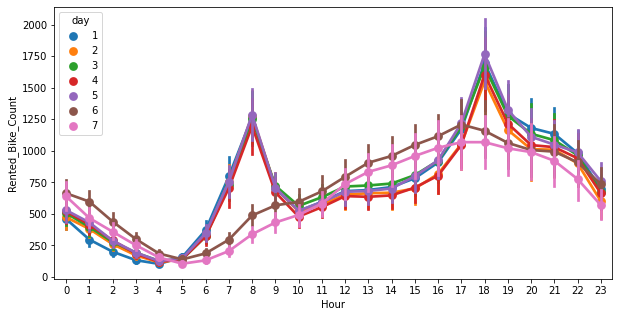

In [ ]:
plt.subplots(figsize = (10,5))
sns.pointplot(data=df, x='Hour', y='Rented_Bike_Count', hue='day')
plt.show()

*We can see that weekdays morning and evenings are time where demand is highest, while weekends demand decreases by evenings*

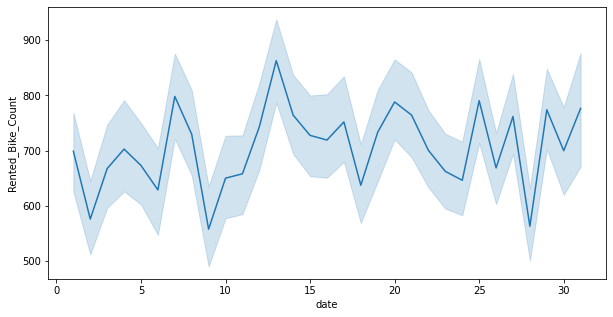

In [ ]:
plt.subplots(figsize = (10,5))
sns.lineplot(data=df, x='date', y='Rented_Bike_Count')
plt.show()

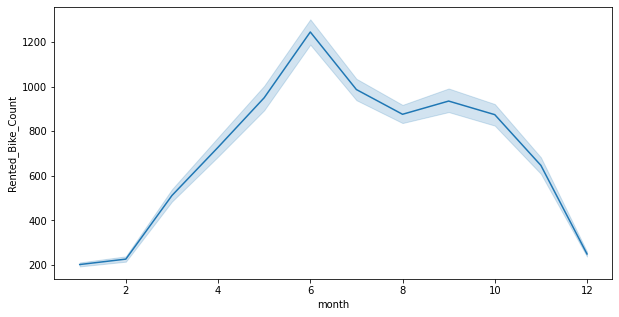

In [ ]:
plt.subplots(figsize = (10,5))
sns.lineplot(data=df, x='month', y='Rented_Bike_Count')
plt.show()

*We can see how the demand is increases towards mid of the month and mid of the year*

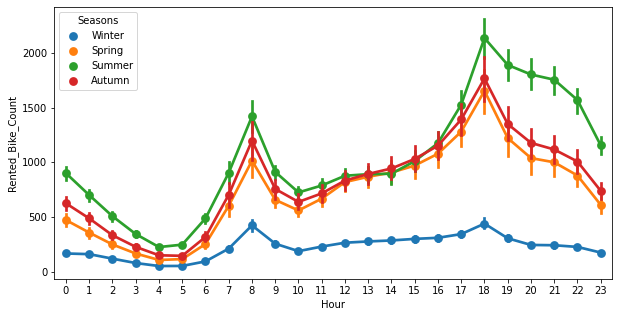

In [ ]:
plt.subplots(figsize = (10,5))
sns.pointplot(data=df, x='Hour', y='Rented_Bike_Count', hue='Seasons')
plt.show()

*Winters have low demand and summers have very high demand during evenings*

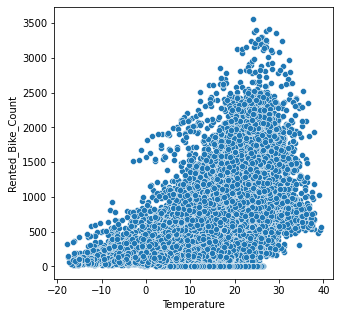

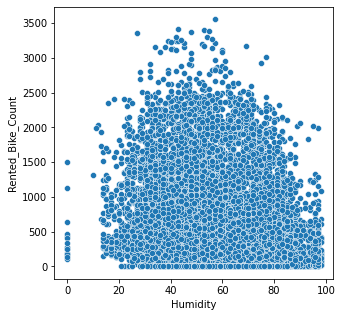

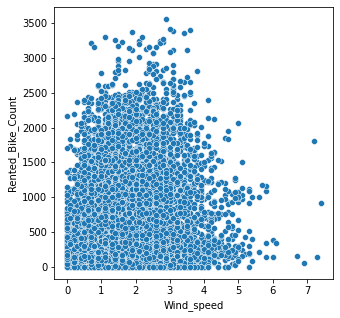

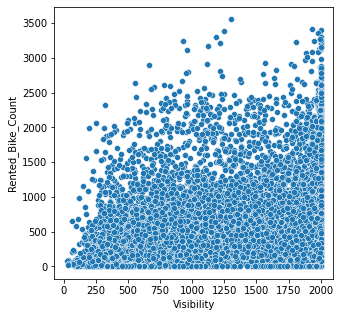

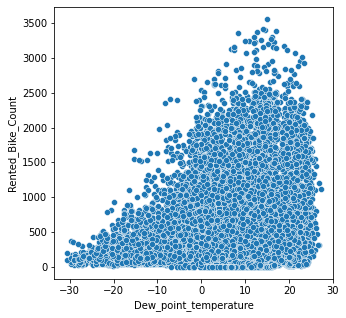

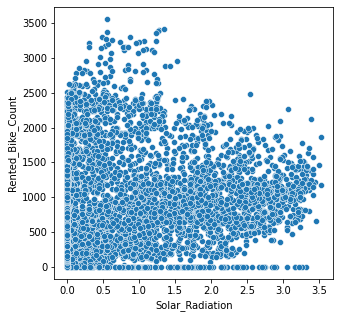

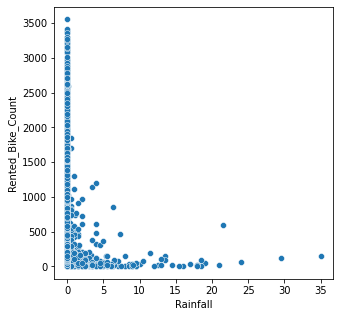

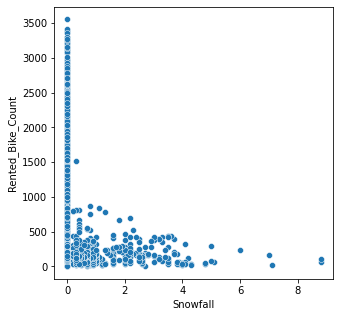

In [ ]:
for var in continous_var:
  plt.subplots(figsize = (5,5))
  sns.scatterplot(data=df, x=var, y='Rented_Bike_Count')
  plt.show()

*We can see huge demands when temperature is pleasant, humidity is average, there is no rainfall or snowfall, good visibility and no to less wind*

### Distribution of continous and discrete variables

#### Continous variables

In [ ]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # boxplot
    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q plot')

    plt.show()

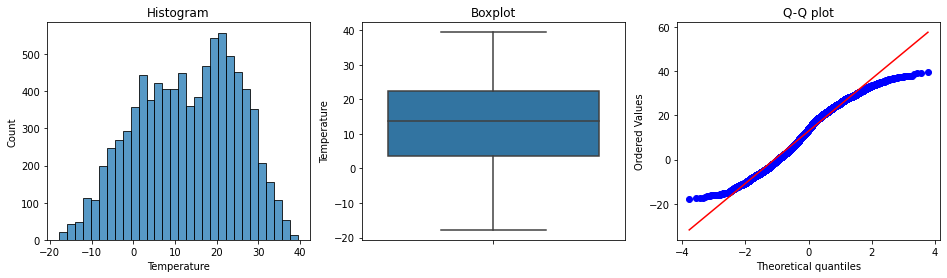

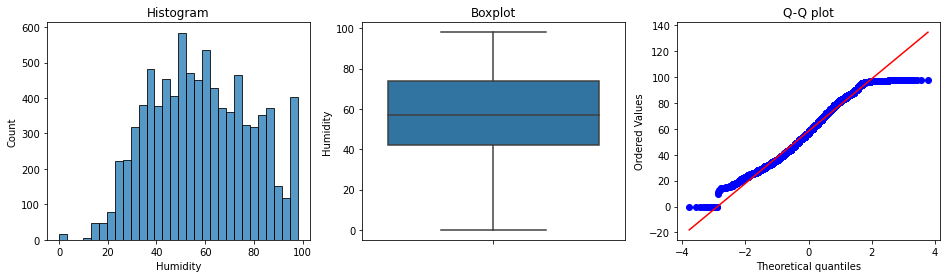

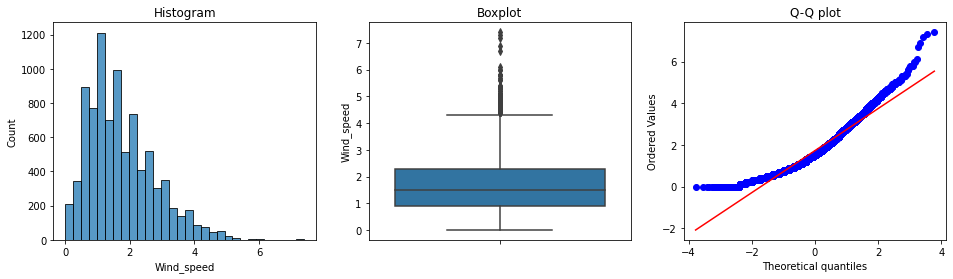

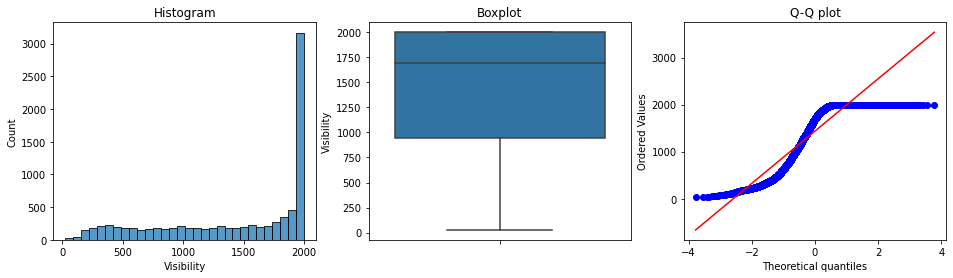

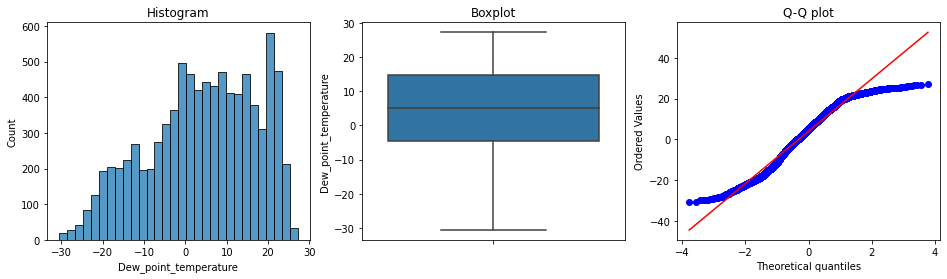

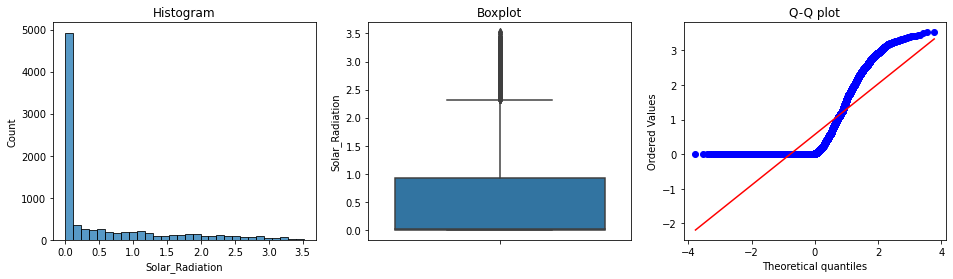

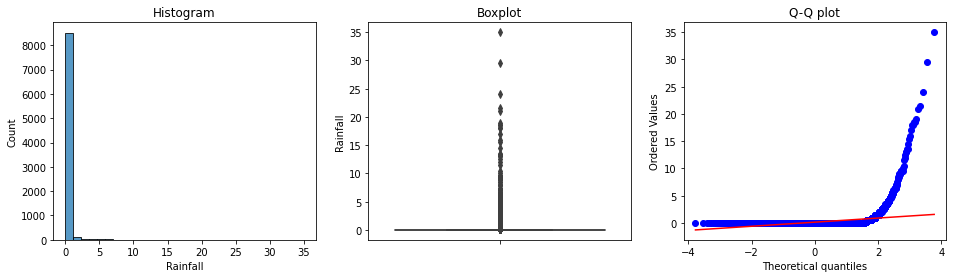

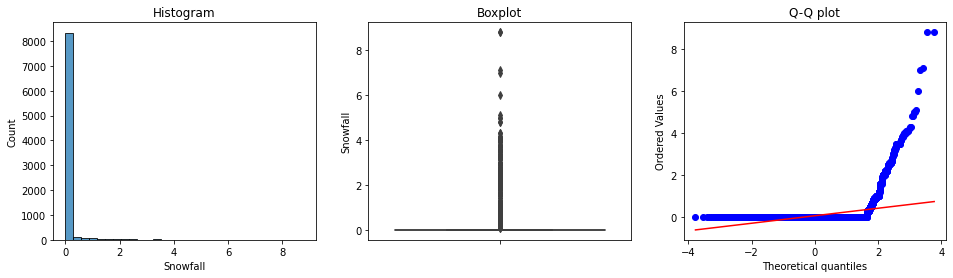

In [ ]:
for var in continous_var:
    diagnostic_plots(df, var)

*There is skewness in the continous variables. we will transform the continous vairables. There are a few continous variables like temperature and dew_point_temperature which has negative values.*

#### Discrete variables

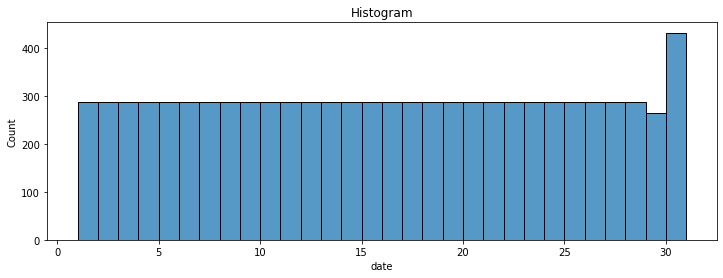

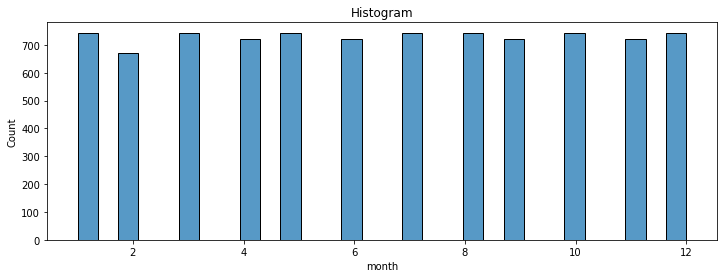

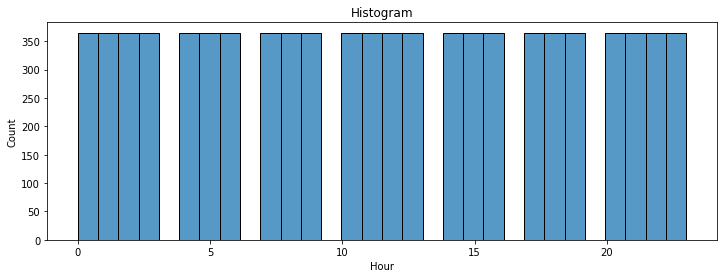

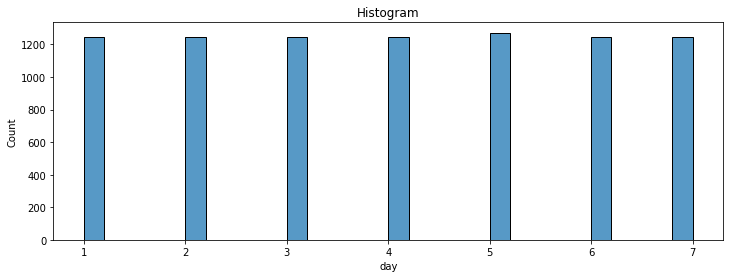

In [ ]:
# histograms for discrete variables
for var in discrete_var:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)
    sns.histplot(df[var], bins=30)
    plt.title('Histogram')

*Discrete variables seems eveny distributed, so we might not need discretization*

### Chekcing for rare category

In [ ]:
def check_rare(var):
  cat_freq = 100 * df[var].value_counts(normalize=True)
  fig = cat_freq.sort_values(ascending=False).plot.bar()
  fig.axhline(y=5, color='red')
  fig.set_ylabel('Category percentage frequency')
  fig.set_xlabel(var)
  fig.set_title('Identifying Rare Categories')
  plt.show()

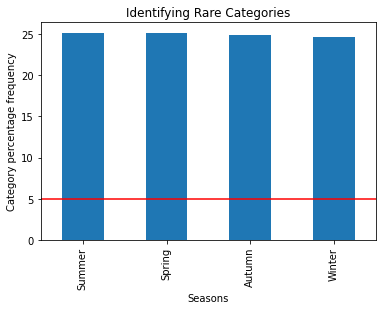

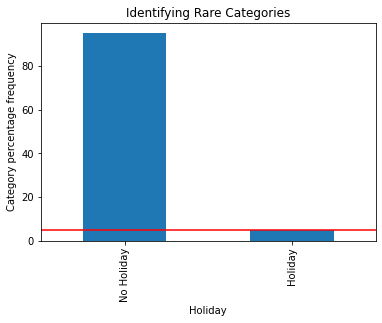

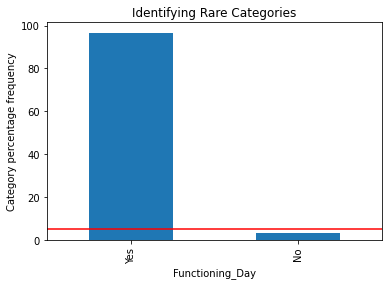

In [ ]:
for var in categorical_var:
  check_rare(var)

*We can see that Functioning_Day No is a rare category*

In [ ]:
rare_columns = ['Holiday','Functioning_Day']

### Visualizing relationship between variables

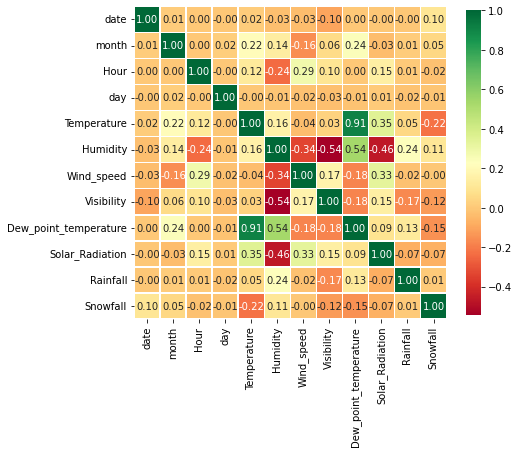

In [ ]:
corrmat = df[discrete_var + continous_var].corr().round(2)
top_corr_features = corrmat.index
plt.figure(figsize=(7, 7))
sns.heatmap(df[top_corr_features].corr(),annot=True, square=True, fmt='.2f', 
            cbar_kws={"shrink": .80}, linewidths=.5, cmap='RdYlGn');

*Temperature and dew_point_temperature are very highly correlated, we can drop one of these. Let's drop dew_point_temperature.*

In [ ]:
continous_var.remove('Dew_point_temperature')

In [ ]:
continous_var

['Temperature',
 'Humidity',
 'Wind_speed',
 'Visibility',
 'Solar_Radiation',
 'Rainfall',
 'Snowfall']

### Distribution of target variable

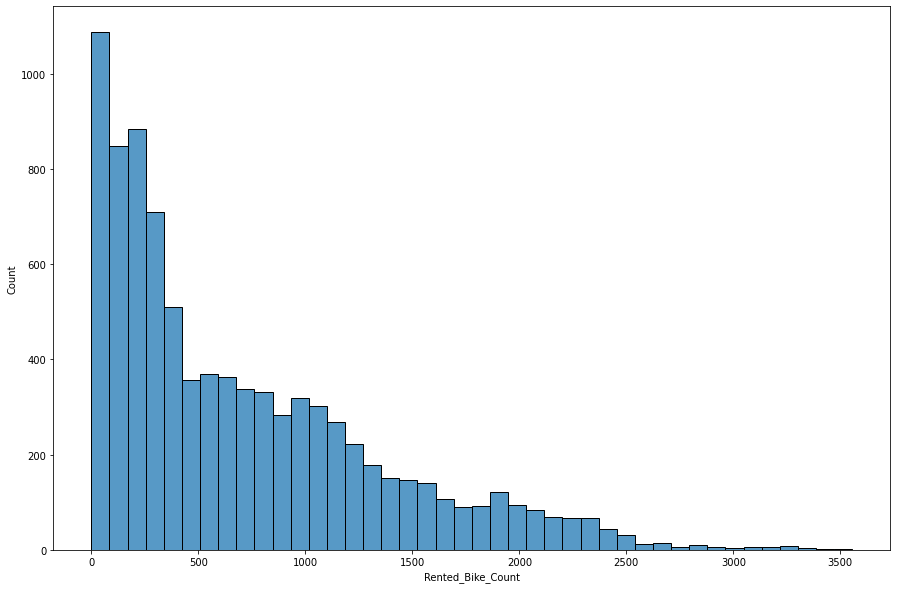

In [ ]:
plt.figure(figsize=(15,10))
sns.histplot(df['Rented_Bike_Count'])
plt.show()

## Conclusions:

*Rare label encoder is required for variable Functioning_Day and Holiday*<br>
*One hot encoding for categorical + discrete variables*<br>
*For temperature variables transformation we will use Yeo Johnson Transformation as there are negative values in temperature, humidity and wind_Speed*<br>
*We will use k-means discretization for Visibility, Rainfall, Solar radiation, snowfall*<br>
*We will scale the variables to have same scale*

## Preprocessing steps

*Rare label encoder for rare_columns*<br>
*One hot encoding for categorical + discrete variables*<br>
*Yeo Johnson transformation for temperature, Humidity, Wind_speed*<br>
*k-means discretization for Visibility, Rainfall, Solar radiation, snowfall to decluster values with more frequency*<br>
*Standard Scaling for continuous variables.*

## Complete Pipeline

### Split dataframe into dependent and independent variables and into train and test

In [ ]:
X = df.drop(['Rented_Bike_Count'], axis =1)
y = df['Rented_Bike_Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

*We are not using stratification because our categorical variables have less data for one class*

### Pipeline

In [ ]:
columns_to_drop = ['Dew_point_temperature']

pipeline = Pipeline([
                           
    ('drop_features',
      DropFeatures(columns_to_drop)),

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05,n_categories=2,variables=rare_columns,replace_with='Rare')),

    ('one_hot_encoder',
      OneHotEncoder(variables=categorical_var+discrete_var, drop_last=True, ignore_format=True)),
    
    ('yeo_johnson_transformer',
      YeoJohnsonTransformer(variables=['Temperature', 'Humidity', 'Wind_speed'])),

    ('discretizer_visibility',
      SklearnTransformerWrapper(KBinsDiscretizer(n_bins=10, encode= 'ordinal', strategy = 'kmeans' ), 
                               variables = ['Visibility'])),

    ('discretizer_solar',
      SklearnTransformerWrapper(KBinsDiscretizer(n_bins=10, encode= 'ordinal', strategy = 'kmeans' ), 
                               variables = ['Solar_Radiation'])),

    ('discretizer_rainfall',
      SklearnTransformerWrapper(KBinsDiscretizer(n_bins=10, encode= 'ordinal', strategy = 'kmeans' ), 
                               variables = ['Rainfall'])),

    ('discretizer_snowfall',
      SklearnTransformerWrapper(KBinsDiscretizer(n_bins=10, encode= 'ordinal', strategy = 'kmeans' ), 
                               variables = ['Snowfall'])),
    
    ('scalar',
      SklearnTransformerWrapper(transformer = StandardScaler(), variables=continous_var)),

    ('knn',
     KNeighborsRegressor())
])

### Hyperparameter tuning - Round 1

In [ ]:
param_grid = {
    'knn__n_neighbors': np.arange(1,5,1)
}
grid_knn = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True)

In [ ]:
warnings.filterwarnings('ignore')
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('drop_features',
                                        DropFeatures(features_to_drop=['Dew_point_temperature'])),
                                       ('rare_label_encoder',
                                        RareLabelEncoder(n_categories=2,
                                                         variables=['Holiday',
                                                                    'Functioning_Day'])),
                                       ('one_hot_encoder',
                                        OneHotEncoder(drop_last=True,
                                                      ignore_format=True,
                                                      variables=['Seasons',
                                                                 'Holiday',
                                                                 'Functioning_Day',
                                                                 'date',
         

In [ ]:
print(grid_knn.best_params_)

{'knn__n_neighbors': 4}


In [ ]:
file_best_estimator_round1 = save_model_folder / 'bike_sharing_round1_best_estimator.pkl'
file_complete_grid_round1 = save_model_folder / 'bike_sharing_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_knn.best_estimator_, file_best_estimator_round1)
joblib.dump(grid_knn, file_complete_grid_round1)

['/content/drive/MyDrive/Colab Notebooks/SeoulBikeSharing/bike_sharing_round1_complete_grid.pkl']

In [ ]:
# load  the best estimator
loaded_best_estimator_round1 = joblib.load(file_best_estimator_round1)

# load complete grid results
loaded_complete_grid_round1 = joblib.load(file_complete_grid_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

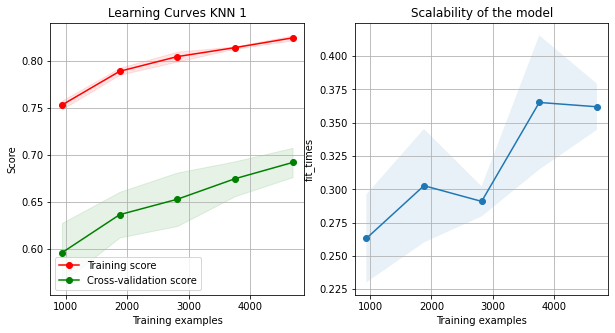

In [ ]:
plot_learning_curve(loaded_best_estimator_round1, 'Learning Curves KNN 1', X_train, y_train, n_jobs=-1)

In [ ]:
print(loaded_best_estimator_round1.score(X_train, y_train))

print(loaded_complete_grid_round1.best_score_)

0.8336760118690103
0.6922244892694961


*We can see the best value for k as 11. Low validation score as compared to training score suggests overfitting. We will change the range for k for same pipeline and check if we get a better cross validations score*

### Hyperparameter tuning - Round 2

{'knn__n_neighbors': 9}
0.7756875321543883
0.7123714905554921


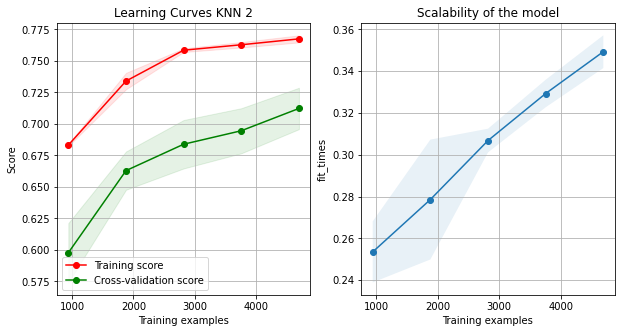

In [ ]:
param_grid2 = {
    'knn__n_neighbors': np.arange(1,11,2)
}
grid_knn2 = GridSearchCV(pipeline, param_grid2, cv=5, return_train_score=True)
warnings.filterwarnings('ignore')
grid_knn2.fit(X_train, y_train)
print(grid_knn2.best_params_)
file_best_estimator_round2 = save_model_folder / 'bike_sharing_round2_best_estimator.pkl'
file_complete_grid_round2 = save_model_folder / 'bike_sharing_round2_complete_grid.pkl'
joblib.dump(grid_knn2.best_estimator_, file_best_estimator_round2)
joblib.dump(grid_knn2, file_complete_grid_round2)
loaded_best_estimator_round2 = joblib.load(file_best_estimator_round2)
loaded_complete_grid_round2 = joblib.load(file_complete_grid_round2)
plot_learning_curve(loaded_best_estimator_round2, 'Learning Curves KNN 2', X_train, y_train, n_jobs=-1)
print(loaded_best_estimator_round2.score(X_train, y_train))
print(loaded_complete_grid_round2.best_score_)

*The best value of k changes to 9. The plot and cross valiation scores for training and validations are better in comparison. We will do one more round by changing the range and see if this improves.*

### Hyperparameter tuning - Round 3

{'knn__n_neighbors': 13}
0.7615928676878938
0.713516525948279


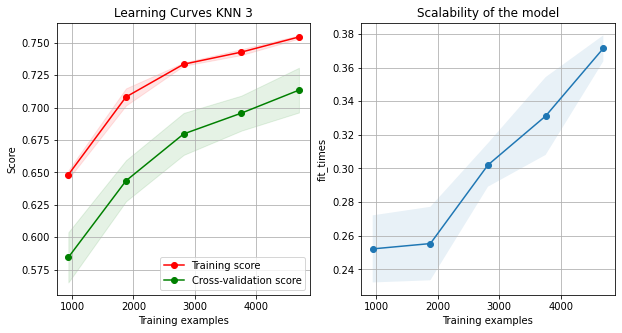

In [ ]:
param_grid3 = {
    'knn__n_neighbors': np.arange(1,15,2)
}
grid_knn3 = GridSearchCV(pipeline, param_grid3, cv=5, return_train_score=True)
warnings.filterwarnings('ignore')
grid_knn3.fit(X_train, y_train)
print(grid_knn3.best_params_)
file_best_estimator_round3 = save_model_folder / 'bike_sharing_round3_best_estimator.pkl'
file_complete_grid_round3 = save_model_folder / 'bike_sharing_round3_complete_grid.pkl'
joblib.dump(grid_knn3.best_estimator_, file_best_estimator_round3)
joblib.dump(grid_knn3, file_complete_grid_round3)
loaded_best_estimator_round3 = joblib.load(file_best_estimator_round3)
loaded_complete_grid_round3 = joblib.load(file_complete_grid_round3)
plot_learning_curve(loaded_best_estimator_round3, 'Learning Curves KNN 3', X_train, y_train, n_jobs=-1)
print(loaded_best_estimator_round3.score(X_train, y_train))
print(loaded_complete_grid_round3.best_score_)

*We can see that although the model complexity has decreased with k now as 13, there is not much change in best training and cross validation score while the scalability tends to decrease. We will do another round of tuning with changes for k*

### Hyperparameter tuning - Round 4

{'knn__n_neighbors': 13}
0.7615928676878938
0.713516525948279


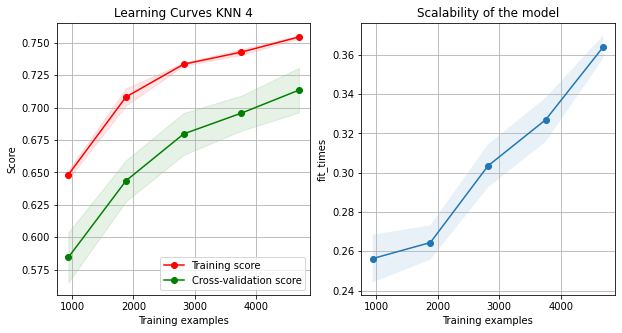

In [ ]:
param_grid4 = {
    'knn__n_neighbors': np.arange(1,21,2)
}
grid_knn4 = GridSearchCV(pipeline, param_grid4, cv=5, return_train_score=True)
warnings.filterwarnings('ignore')
grid_knn4.fit(X_train, y_train)
print(grid_knn4.best_params_)
file_best_estimator_round4 = save_model_folder / 'bike_sharing_round4_best_estimator.pkl'
file_complete_grid_round4 = save_model_folder / 'bike_sharing_round4_complete_grid.pkl'
joblib.dump(grid_knn4.best_estimator_, file_best_estimator_round4)
joblib.dump(grid_knn4, file_complete_grid_round4)
loaded_best_estimator_round4 = joblib.load(file_best_estimator_round4)
loaded_complete_grid_round4 = joblib.load(file_complete_grid_round4)
plot_learning_curve(loaded_best_estimator_round4, 'Learning Curves KNN 4', X_train, y_train, n_jobs=-1)
print(loaded_best_estimator_round4.score(X_train, y_train))
print(loaded_complete_grid_round4.best_score_)

*By doing 4 rounds of hyperparameter tuning, we can see that optimum value of k is 13 at round 3. We will fit Test data into model acheived in round 3*

### Best model fit on test data

In [ ]:
print(f'Test data accuracy for round 3: { loaded_best_estimator_round3.score(X_test, y_test)}')

Test data accuracy for round 3: 0.7078335633142052


### Calculate error

In [ ]:
y_hat = grid_knn3.predict(X_test)
error = y_test.values - y_hat
rmse = np.sqrt(np.mean(np.power(error,2)))
print(rmse)

345.1014722295098
